In [51]:
from scipy.ndimage import rotate, shift
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib as mpl
from sklearn.linear_model import LinearRegression
import scipy.stats as sp
import pandas as pd
import statsmodels.api as sm
import math
import cmath
import seaborn as sns

g=np.array([[[3,2,1],[3,2,1],[3,2,1]],[[3,2,1],[3,2,1],[3,2,1]],[[3,2,1],[3,2,1],[3,2,1]]])
a,b,c=np.where(g>1)
v=np.array([0,1])
g[v][v][v]=0
print(g)

[[[3 2 1]
  [3 2 1]
  [3 2 1]]

 [[3 2 1]
  [3 2 1]
  [3 2 1]]

 [[3 2 1]
  [3 2 1]
  [3 2 1]]]


In [52]:
#INPUT
stability = 1 #set from 1-6                              

measured_x = 63                                                   
measured_y = 38                                                         
measured_z = 0                                                          

stack_x = 34
stack_y = 13
stack_height = 4       
emission_rate = 1                                                                     
windspeed=4.7
wind_direction=90


In [53]:
#GRID & STEPSIZE CALCULATION 

stability_str = ['Very unstable', 'Moderately unstable', 'Slightly unstable', 'Neutral', 'Moderately stable', 'Very stable'] # Possibly Useless
ssv= stability_str[stability] # Possibly Useless
x_range=np.arange(-100,100,0.5)
y_range=np.arange(-100,100,0.5)
z_range=np.arange(0,50,0.5)
X,Y,Z = np.meshgrid(x_range,y_range,z_range)

In [54]:
#WIND RELATED CALCULATIONS

height_slice_direction= math.atan2(measured_y - stack_y, measured_x - stack_x) *(180/(math.pi))
x_origin=X-stack_x
y_origin=Y-stack_y

wind_xcomponent=windspeed*math.sin(math.radians(wind_direction-180))
wind_ycomponent=windspeed*math.cos(math.radians(wind_direction-180))

#print(wind_xcomponent, wind_ycomponent)

dot_product=wind_xcomponent*x_origin+wind_ycomponent*y_origin
magnitudes= windspeed*((x_origin**2)+(y_origin**2))**0.5
print(np.shape(dot_product), np.shape(magnitudes))
ix,iy,iz= np.where(magnitudes==0)
magnitudes[ix,iy,iz]=math.pi/2
print(magnitudes[0][0][0])
subtended=np.arccos(dot_product/magnitudes)
hypotenuse=((x_origin**2)+(y_origin**2))**0.5
downwind=np.cos(subtended)*hypotenuse
downwindimag=np.vectorize(complex)(downwind.real, downwind.imag)
print(())


(400, 400, 100) (400, 400, 100)
823.841762719031
()


In [55]:
#PASQUILL CONSTANTS & SIGMA CALCULATION

stability_class= {1 : (122.8,0.94470,24.1670,2.5334),
                  2: (90.673, 0.93198, 18.3330, 1.8096),
                  3: (61.141, 0.91465, 12.5, 1.0857),
                  4: (34.459, 0.86974, 8.3330, 0.72382),
                  5: (24.26, 0.83660, 6.25, 0.54287),
                  6: (15.209, 0.81558, 4.1667, 0.36191)
                 }
P_a=stability_class[stability][0] 
P_b=stability_class[stability][1]
P_c=stability_class[stability][2]
P_d=stability_class[stability][3]

sig_z = P_a*(abs((X/1000))**P_b)
sig_z[sig_z > 5000] = 5000
theta=0.017453293*(P_c-P_d*np.log((downwindimag/1000)))
sig_y=(465.11628*downwind/1000)*np.tan(theta)

C:\Users\danin\AppData\Local\Temp\ipykernel_17376\1855627828.py:17: RuntimeWarning: divide by zero encountered in log
  theta=0.017453293*(P_c-P_d*np.log((downwindimag/1000)))
C:\Users\danin\AppData\Local\Temp\ipykernel_17376\1855627828.py:17: RuntimeWarning: invalid value encountered in multiply
  theta=0.017453293*(P_c-P_d*np.log((downwindimag/1000)))


In [58]:
#CROSSWIND AND GAUSSIAN FORMULA

crosswind=np.sin(subtended)*hypotenuse
indix,indiy,indiz=np.where((downwind > 0))
#print(len(indix),indiy,indiz)
print(np.shape(X))
#indix][indiy[indiz]=np.where((Z==0) & (downwind > 0))
#print(np.shape(indix),np.shape(indiy),np.shape(indiz),np.shape(np.where(downwind > 0)))
Concentration= np.zeros(np.shape(downwind))
Concentration[indix,indiy,indiz] =(emission_rate/(2*math.pi*windspeed*sig_y[indix,indiy,indiz]*sig_z[indix,indiy,indiz])*math.e**(-crosswind[indix,indiy,indiz]*2/(2*sig_y[indix,indiy,indiz]*2))* (math.e**(-(Z[indix,indiy,indiz]-stack_height)**2/(2*sig_z[indix,indiy,indiz]*2))+ math.e**(-(Z[indix,indiy,indiz]-stack_height)**2/(2*sig_z[indix,indiy,indiz]**2))))
(Concentration)
#Concentration[indix][indiy][indiz] =np.real(emission_rate/(2*math.pi*windspeed*sig_y[indix][indiy][indiz]*sig_z[indix][indiy][indiz])*math.e**(-crosswind[indix][indiy][indiz]*2/(2*sig_y[indix][indiy][indiz]*2))* (math.e**(-(Z[indix][indiy][indiz]-stack_height)**2/(2*sig_z[indix][indiy][indiz]*2))+ math.e**(-(Z[indix][indiy][indiz]-stack_height)**2/(2*sig_z[indix][indiy][indiz]**2))))
#Concentration =emission_rate/(2*math.pi*windspeed*sig_y[indices]*sig_z[indices])*math.e**(-crosswind[indices]**2/(2*sig_y[indices]**2))* (math.e**(-(-stack_height)**2/(2*sig_z[indices]**2))+ math.e**(-(stack_height)**2/(2*sig_z[indices]**2)) )
#Concentration=np.real(Concentration)
#print(Concentration,np.shape(Concentration),len(x_range)*len(y_range))
#maybe way to calculate area of plume over whole facility

(400, 400, 100)


C:\Users\danin\AppData\Local\Temp\ipykernel_17376\3080784554.py:10: RuntimeWarning: divide by zero encountered in divide
  Concentration[indix,indiy,indiz] =(emission_rate/(2*math.pi*windspeed*sig_y[indix,indiy,indiz]*sig_z[indix,indiy,indiz])*math.e**(-crosswind[indix,indiy,indiz]*2/(2*sig_y[indix,indiy,indiz]*2))* (math.e**(-(Z[indix,indiy,indiz]-stack_height)**2/(2*sig_z[indix,indiy,indiz]*2))+ math.e**(-(Z[indix,indiy,indiz]-stack_height)**2/(2*sig_z[indix,indiy,indiz]**2))))
C:\Users\danin\AppData\Local\Temp\ipykernel_17376\3080784554.py:10: RuntimeWarning: invalid value encountered in divide
  Concentration[indix,indiy,indiz] =(emission_rate/(2*math.pi*windspeed*sig_y[indix,indiy,indiz]*sig_z[indix,indiy,indiz])*math.e**(-crosswind[indix,indiy,indiz]*2/(2*sig_y[indix,indiy,indiz]*2))* (math.e**(-(Z[indix,indiy,indiz]-stack_height)**2/(2*sig_z[indix,indiy,indiz]*2))+ math.e**(-(Z[indix,indiy,indiz]-stack_height)**2/(2*sig_z[indix,indiy,indiz]**2))))
C:\Users\danin\AppData\Local\Te

array([[[2.35795772e-05, 2.44272367e-05, 2.52032211e-05, ...,
         8.49197928e-08, 7.56932558e-08, 6.73825319e-08],
        [2.36229601e-05, 2.44766061e-05, 2.52582494e-05, ...,
         8.11200497e-08, 7.22272605e-08, 6.42259663e-08],
        [2.36661583e-05, 2.45258489e-05, 2.53132086e-05, ...,
         7.74352750e-08, 6.88699080e-08, 6.11718114e-08],
        ...,
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],

       [[2.37490101e-05, 2.46027606e-05, 2.53843208e-05, ...,
         8.55299908e-08, 7.62371557e-08, 6.78667145e-08],
        [2.37932765e-05, 2.46530771e-05, 2.54403559e-05, ...,
         8.17049078e-08, 7.27480035e-08, 6.46890217e-08],
        [2.38373631e-05, 

ValueError: cannot reshape array of size 16000000 into shape (1,100)

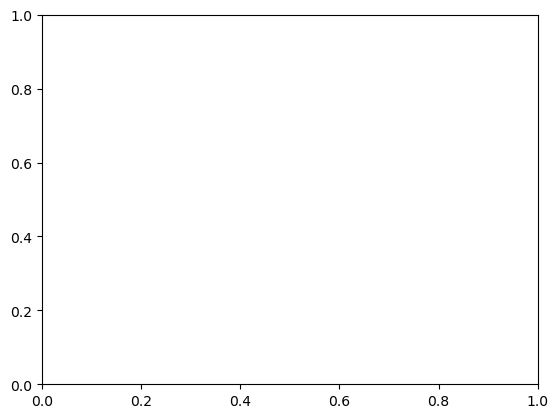

In [66]:
#PLOTTING IN 2D
Concentration2D=Concentration[:, :, 0]
plt.pcolormesh(x_range,y_range,Concentration2D)

In [ ]:
sns.heatmap(df)

NameError: name 'sns' is not defined